In [1]:
import numpy as np
import Backgammon as B
import agent as A
import flipped_agent as FA
import tensorflow as tf
import keras
import keras.layers as L
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from collections import deque
import time
import os.path

Using TensorFlow backend.


In [2]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        boards = np.vstack(boards)
        return moves, boards
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player = 1):
        old_board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return old_board, np.copy(self.board), reward, self.done
    
    def symbolic_step(self, move):
        board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                board = B.update_board(board = board, move = m, player = 1)
        reward = 0
        done = False
        if B.game_over(board):
            reward = 1
            done = True
        return board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

# PolicyGrad Agent

In [3]:
class PolicyGradient:
    def __init__(self, sess, gamma = 0.99, learning_rate = 1e-3, entropy = 0.1,
                epsilon = 1, epsdecay = 0.999):
        
        self._gamma = gamma
        self._epsilon = epsilon
        self._epsdecay = epsdecay
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.network = keras.models.Sequential()
        self.network.add(L.Dense(32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(1))
        
        # Predictions
        
        ## Actor
        self._actor_logits = self.network(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * self._cumulative_rewards)
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._actor_loss)
        
        self._s = sess
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        if np.random.uniform() < self._epsilon:
            action = np.random.choice(np.arange(len(probs)), p = probs)
        else:
            action = np.argmax(probs)
            
        return action
    
    def update(self, states, rewards, afterstates, done):
        self._s.run(self._update, 
                    ({self._states: states, 
                      self._cumulative_rewards: rewards}))
        self._epsilon *= self._epsdecay
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R
    
    def ExamplePolicy(self):
        _, st = B.legal_moves(B.init_board(), B.roll_dice(), 1)
        
        out = np.round(self._s.run(self._actor_policy, ({self._states: st})) * 100)/100
        out = out.flatten()
        out.sort()
        return out[::-1]

# Actor Critic (Shared network)

In [4]:
class ActorCritic:
    def __init__(self, sess, gamma = 0.99, learning_rate = 0.001, entropy = 0.01, 
                 read_file = True, save_path = "ACModelTF.h5"):
        
        self._gamma = gamma
        self._iters = 0
        self._path = save_path
        
        self._currstates = tf.placeholder("float32", (None, 29), name = "CurrentStates")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "AfterStates")
        self._is_terminal = tf.placeholder("float32", (None, 1), name = "IsTerminal")
        self._cumulative_rewards = tf.placeholder("float32", (None, 1), name = "Rewards")
        self._s = sess
        
        # Network
        if os.path.isfile(self._path) and read_file:
            self._network = keras.models.load_model(self._path)
        else:
            self._network = keras.models.Sequential()
            self._network.add(L.Dropout(0.2))
            self._network.add(L.Dense(32, 
                                      kernel_regularizer = keras.regularizers.l2(0.01),
                                      kernel_initializer = keras.initializers.glorot_normal(seed=None)))
            self._network.add(L.LeakyReLU())
            self._network.add(L.Dense(64,
                                      kernel_regularizer = keras.regularizers.l2(0.01),
                                      kernel_initializer = keras.initializers.glorot_normal(seed=None)))
            self._network.add(L.LeakyReLU())
            self._network.add(L.Dense(32, 
                                      kernel_regularizer = keras.regularizers.l2(0.01),
                                      kernel_initializer = keras.initializers.glorot_normal(seed=None)))
            self._network.add(L.LeakyReLU())
            self._network.add(L.Dense(1))
        
        
        
        # Predictions
        ## Critic
        self._current_state_values = tf.nn.tanh(self._network(self._currstates))
        self._afterstate_values = tf.nn.tanh(self._network(self._afterstates)) * (1 - self._is_terminal)
        
        self._target_state_values = self._cumulative_rewards
        self._target_state_values += self._gamma * self._afterstate_values * (1 - self._is_terminal)
        
        self._advantage = self._target_state_values - self._current_state_values
        
        ## Actor
        self._actor_logits = self._network(self._afterstates)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._critic_loss = -tf.reduce_sum(tf.stop_gradient(self._advantage) * self._current_state_values)
        self._actor_loss = -tf.reduce_sum(tf.stop_gradient(self._advantage) * self._actor_log_policy)
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._actor_loss + self._critic_loss)
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._afterstates: states})).flatten()
            
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, currstates, afterstates, cumulative_rewards, is_terminal):
        
        self._s.run(self._update, 
                    ({self._currstates: currstates,
                      self._afterstates: afterstates, 
                      self._is_terminal: is_terminal,
                      self._cumulative_rewards: cumulative_rewards}))
        self._iters += 1
        
        if self._iters % 1000 == 0:
            self.save_network()
        
    def get_cumulative_rewards(self, rewards):
        reward = rewards[-1]
        i = np.arange(len(rewards))[::-1]
        R = reward * (self._gamma ** i)
        return R
    
    def ExamplePolicy(self):
        _, st = B.legal_moves(B.init_board(), B.roll_dice(), 1)
        
        out = np.round(self._s.run(self._actor_policy, ({self._afterstates: st})) * 100)/100
        out = out.flatten()
        out.sort()
        return out[::-1]
    
    def __str__(self):
        return(str(self._network.summary()))
    
    def save_network(self):
        self._network.save(self._path)

# Random Agent

In [ ]:
class RandomAgent:
    def __init__(self):
        self.type = "Random"
    def sample_action(self, states):
        action = np.random.randint(len(states))
        return(action)
        

# Function to play game

In [5]:
def PlayRandomAgent(player, n_games = 100):
    wins = []

    for _ in range(n_games):

        env = backgammon()
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = env.step(possible_moves[action])

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        old_board, new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = -1
                            break

        wins.append(float(reward == 1))
        
    return(np.mean(wins))

In [6]:
def SelfPlay(player, n_games = 1000, test_each = 100, test_games = 10):
    win_pct = []
    for i in range(n_games):
        env = backgammon()

        active = 0

        currstates = [[], []]
        afterstates = [[], []]
        rewards = [[], []]
        is_terminal = [[], []]
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = env.step(possible_moves[action], player = 1)

                rewards[active].append(reward)
                currstates[active].append(old_board)
                afterstates[active].append(new_board)

                if done:
                    rewards[(active + 1) % 2][-1] = -1

                    is_terminal[active].append(1)
                    is_terminal[(active + 1) % 2][-1] = 1
                    break
                else:
                    is_terminal[active].append(0)
                env.swap_player()
                active = (active + 1) % 2
        CurrStates = np.vstack([np.vstack(player_data) for player_data in currstates])
        AfterStates = np.vstack([np.vstack(player_data) for player_data in afterstates])
        CumulativeRewards = np.vstack([np.vstack(player.get_cumulative_rewards(player_data)) for player_data in rewards])
        IsTerminal = np.vstack([np.vstack(player_data) for player_data in is_terminal])


        player.update(currstates = CurrStates, 
                      afterstates = AfterStates, 
                      cumulative_rewards = CumulativeRewards,
                      is_terminal = IsTerminal)
        
        if (i + 1) % test_each == 0:
            outcome = PlayRandomAgent(player, n_games = test_games)
            win_pct.append(outcome)
            example = player.ExamplePolicy()
            clear_output(True)
            print("Win percentage: %.5f" % (win_pct[-1]))
            print("Example policy: \n", example)
            
            plt.figure()
            x = [(n + 1) * test_each for n in range(len(win_pct))]
            y = (100*np.array(win_pct)).astype('int')
            plt.plot(x, y)
            plt.xlabel('Episode')
            plt.ylabel('Win percentage of last 100 episodes')
            plt.ylim(0, 100)
            plt.show()

# Batch environment

In [ ]:
AC = ActorCritic(sess = s, entropy = 0, learning_rate = 0.0003, gamma = 0.99)

In [ ]:
class Batchgammon:
    def __init__(self, n_envs = 10):
        self.envs = [backgammon() for _ in range(n_envs)]
        self.n_envs = n_envs
        
        self.currstates = [[[], []] for i in range(self.n_envs)]
        self.afterstates = [[[], []] for i in range(self.n_envs)]
        self.rewards = [[[], []] for i in range(self.n_envs)]
        self.is_terminal = [[[], []] for i in range(self.n_envs)]
        
        self.active = np.zeros(n_envs)
        self.dice = []
        
        
        self.playedgames = 0
        
    def reset(self):
        return np.array([env.reset() for env in self.envs])
    
    def legal_moves(self, dice, player):
        info =  [B.legal_moves(board = env.board, dice = d, player = p)
                for env, d, p in zip(self.envs, dice, player)]
        
        moves, boards = [item for item in zip(*info)]
        
        boards = [np.vstack(board) for board in boards]
        
        return moves, boards
    
    def step(self, player):
        self.dice = [B.roll_dice() for i in range(n_envs)]
        
        
        info =  [B.legal_moves(board = env.board, dice = d, player = p)
                for env, d, p in zip(self.envs, self.dice, self.active)]
        
        moves, boards = [item for item in zip(*info)]
        
        boards = [np.vstack(board) for board in boards]
        action = player.sample_action(possible_boards)
        results = [env.step(a) for env, a, d in zip(self.envs, actions, self.dice)]
        
        old_boards, new_boards, rewards, done = map(np.array, zip(*results))
        
        self.active = (self.active + 1) % 2
        
        for i in range(len(self.envs)):
            self.currstates[i][player[i]].append(old_boards[i])
            self.afterstates[i][player[i]].append(new_boards[i])
            self.rewards[i][player[i]].append(rewards[i])
            self.isterminal[i][player[i]].append(done[i])
            
            if done[i]:
                CurrStates = np.vstack([np.vstack(player_data) 
                                        for player_data in self.currstates[i]])
                AfterStates = np.vstack([np.vstack(player_data) 
                                         for player_data in self.afterstates[i]])
                CumulativeRewards = np.vstack([np.vstack(player.get_cumulative_rewards(player_data)) 
                                               for player_data in self.rewards[i]])
                IsTerminal = np.vstack([np.vstack(player_data) 
                                        for player_data in self.is_terminal[i]])


                player.update(currstates = CurrStates, 
                              afterstates = AfterStates, 
                              cumulative_rewards = CumulativeRewards,
                              is_terminal = IsTerminal)
        
                self.envs[i] = backgammon()
                self.active[i] = 0
                self.playedgames += 1

In [8]:
def AsyncSelfPlay(player, n_envs = 10, n_games = 1000, test_each = 100, test_games = 10):
    win_pct = []
    envs = [backgammon() for i in range(n_envs)]
    played_games = 0
    currstates = [[[], []] for i in range(n_envs)]
    afterstates = [[[], []] for i in range(n_envs)]
    rewards = [[[], []] for i in range(n_envs)]
    is_terminal = [[[], []] for i in range(n_envs)]

    active = np.zeros(n_envs, dtype = "int")

    while played_games < n_games:
        for i in range(n_envs):
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = envs[i].legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                
                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = envs[i].step(possible_moves[action], player = 1)
                
                currstates[i][active[i]].append(old_board)
                rewards[i][active[i]].append(reward)
                afterstates[i][active[i]].append(new_board)

                if done:
                    rewards[i][(active[i] + 1) % 2][-1] = -1

                    is_terminal[i][active[i]].append(1)
                    is_terminal[i][(active[i] + 1) % 2][-1] = 1
                    
                    CurrStates = np.vstack([np.vstack(player_data) 
                                            for player_data in currstates[i]])
                    AfterStates = np.vstack([np.vstack(player_data) 
                                             for player_data in afterstates[i]])
                    CumulativeRewards = np.vstack([np.vstack(player.get_cumulative_rewards(player_data)) 
                                                   for player_data in rewards[i]])
                    IsTerminal = np.vstack([np.vstack(player_data) 
                                            for player_data in is_terminal[i]])


                    player.update(currstates = CurrStates, 
                                  afterstates = AfterStates, 
                                  cumulative_rewards = CumulativeRewards,
                                  is_terminal = IsTerminal)
                    
                    envs[i] = backgammon()
                    currstates[i] = [[], []]
                    afterstates[i] = [[], []]
                    rewards[i] = [[], []]
                    is_terminal[i] = [[], []]
                    
                    played_games += 1
                    
                    break
                else:
                    is_terminal[i][active[i]].append(0)
                envs[i].swap_player()
                active[i] = (active[i] + 1) % 2
            

        if (played_games + 1) % test_each == 0:
            outcome = PlayRandomAgent(player, n_games = test_games)
            win_pct.append(outcome)
            example = player.ExamplePolicy()
            clear_output(True)
            print("Win percentage: %.5f" % (win_pct[-1]))
            print("Example policy: \n", example)

            plt.figure()
            x = [(n + 1) * test_each for n in range(len(win_pct))]
            y = (100*np.array(win_pct)).astype('int')
            plt.plot(x, y)
            plt.xlabel('Episode')
            plt.ylabel('Win percentage of last 100 episodes')
            plt.ylim(0, 100)
            plt.show()

In [ ]:
s = tf.InteractiveSession()

In [19]:
AC = ActorCritic(sess = s, entropy = 0.1, learning_rate = 0.0005, gamma = 0.99, read_file = False)

In [13]:
print(AC)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                960       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
__________

Win percentage: 0.95000
Example policy: 
 [0.09 0.09 0.06 0.06 0.06 0.06 0.05 0.05 0.04 0.04 0.03 0.03 0.03 0.03
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01
 0.01 0.01 0.01]


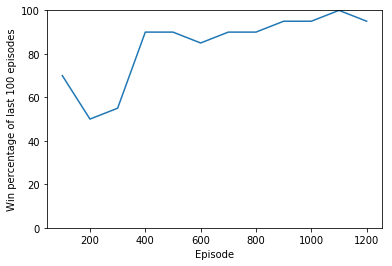

In [ ]:
AsyncSelfPlay(player = AC, n_envs = 50, test_each = 100, test_games = 20)

# Stakt episode


## Spila við sjálft sig

In [ ]:
win_pct = []


for i in range(50):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        currstates = []
        afterstates = []
        rewards = []
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                currstates.append(env.board)
                
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                afterstates.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = AC.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
        
        IsTerminal = np.zeros(len(currstates))
        IsTerminal[-1] = 1
        CumulativeRewards = AC.get_cumulative_rewards(rewards)
        CurrStates = np.vstack(currstates)
        AfterStates = np.vstack(afterstates)
        
        AC.update(currstates = CurrStates,
                  afterstates = AfterStates, 
                  rewards = CumulativeRewards,
                  is_terminal = IsTerminal)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100*np.array(win_pct)).astype('int')
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

In [ ]:
win_pct = []
AC._epsilon = 0
for i in range(100):

    wins = []

    for _ in range(50):

        env = backgammon()

        #states = []
        #currstates = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                #currstates.append(env.board)
                #afterstates.append(env.board)

                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)

                #rewards.append(reward)
                #states.append(new_board)

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = -1
                            break

        #afterstates.append(new_board)
        #afterstates = afterstates[2:]

        #Dones = np.zeros(len(states))
        #Dones[-1] = 1

        #States = np.vstack(states)
        #CurrStates = np.vstack(currstates)
        #AfterStates = np.vstack(afterstates)
        #Rewards = AC.get_cumulative_rewards(rewards)


        #AC.update(states = States, 
        #          rewards = Rewards, 
        #          currstates = CurrStates,
        #          afterstates = AfterStates, 
        #          done = Dones)

        wins.append(int(reward == 1))

    win_pct.append(np.mean(wins))

    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100 * np.array(win_pct)).astype('int')
    plt.plot(x, y) 
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.ylim(0, 100)
    #plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

In [ ]:
win_pct = []
#AC = ActorCritic(sess = s, entropy = 0.01, learning_rate = 0.001, gamma = 0.99,
#                epsilon = 1, epsdecay = 0.999)
for i in range(10):

    wins = []

    for _ in range(50):

        env = backgammon()

        states = []
        currstates = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                currstates.append(env.board)
                afterstates.append(env.board)

                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)

                rewards.append(reward)
                states.append(new_board)

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break

        afterstates.append(new_board)
        afterstates = afterstates[2:]

        Dones = np.zeros(len(states))
        Dones[-1] = 1

        States = np.vstack(states)
        CurrStates = np.vstack(currstates)
        AfterStates = np.vstack(afterstates)
        Rewards = AC.get_cumulative_rewards(rewards)


        AC.update(states = States, 
                  rewards = Rewards, 
                  currstates = CurrStates,
                  afterstates = AfterStates, 
                  done = Dones)

        wins.append(int(rewards[-1] == 1))

    win_pct.append(np.mean(wins))

    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100 * np.array(win_pct)).astype('int')
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.ylim(0, 100)
    #plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

## Spila við random agent

In [ ]:
win_pct = np.zeros([10, 10])

for j in range(10):
    AC = ActorCritic(sess = s, entropy = 0.01, learning_rate = 1e-3, gamma = 0.99)
    for i in range(10):

        wins = []

        for _ in range(100):

            env = backgammon()

            states = []
            currstates = []
            afterstates = []
            rewards = []
            afterstates.append([])
            done = False

            while not done:
                dice = B.roll_dice()
                for _ in range(1 + int(dice[0] == dice[1])):

                    possible_moves, possible_boards = env.legal_moves(dice, 1)
                    n_actions = len(possible_moves)

                    if n_actions == 0:
                        break

                    currstates.append(env.board)
                    afterstates.append(env.board)

                    action = AC.sample_action(possible_boards)
                    new_board, reward, done = env.step(possible_moves[action], player = 1)

                    rewards.append(reward)
                    states.append(new_board)

                    if done:
                        break

                if not done:
                    dice = B.roll_dice()

                    for _ in range(1 + int(dice[0] == dice[1])):
                            new_board, reward, done = env.make_move(dice)
                            if done:
                                rewards[-1] = -1
                                break

            afterstates.append(new_board)
            afterstates = afterstates[2:]

            Dones = np.zeros(len(states))
            Dones[-1] = 1

            States = np.vstack(states)
            CurrStates = np.vstack(currstates)
            AfterStates = np.vstack(afterstates)
            Rewards = AC.get_cumulative_rewards(rewards)


            AC.update(states = States, 
                      rewards = Rewards, 
                      currstates = CurrStates,
                      afterstates = AfterStates, 
                      done = Dones)

            wins.append(int(rewards[-1] == 1))

        win_pct[i, j] = np.mean(wins)

        clear_output(True)
        print("Win percentage: ", win_pct[-1])
        plt.figure()
        x = [(n + 1) * 100 for n in range(10)]
        y = (100 * win_pct).astype('int')
        plt.plot(x, y, 'o-', color = "b")
        plt.xlabel('Episode')
        plt.ylabel('Win percentage of last 100 episodes')
        plt.savefig('tensorflow_random.pdf')
        plt.show()
        print("Example policy: \n", AC.ExamplePolicy())
    

In [ ]:
plt.figure()
x = [(n + 1) * 100 for n in range(10)]
y = (100 * np.mean(win_pct, axis = 1)).astype('int')
plt.plot(x, y, 'o-')
plt.xlabel('Episode')
plt.ylabel('Win percentage of last 100 episodes')
plt.savefig('tensorflow_random.pdf')
plt.show()

# Þjálfa Player2 (Policy Gradient)

In [ ]:
win_pct = []


for i in range(10):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        states = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = PG.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(new_board)
                afterstates.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                            
        afterstates.append(new_board)
        afterstates = afterstates[2:]
        
        Dones = np.zeros(len(states))
        Dones[-1] = 1
        
        States = np.vstack(states)
        Rewards = PG.get_cumulative_rewards(rewards)
        AfterStates = np.vstack(afterstates)
        
        
        PG.update(states = States, 
                      rewards = Rewards, 
                      afterstates = AfterStates, 
                      done = Dones)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print(PG.ExamplePolicy())
    

# PG vs. Random agent

In [ ]:
win_pct = []


for i in range(5):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        #states = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = PG.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                #rewards.append(reward)
                #states.append(old_board)
                #afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = 0
                            break
                            
        #afterstates.append(old_board)
        #afterstates = afterstates[2:]
        
        #Dones = np.zeros(len(states))
        #Dones[-1] = 1
        
        #States = np.vstack(states)
        #Rewards = player.get_cumulative_rewards(rewards)
        #AfterStates = np.vstack(afterstates)
        
        
        #player.update(states = States, 
        #              rewards = Rewards, 
        #              afterstates = AfterStates, 
        #              done = Dones)
        
        wins.append(reward)
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    

# Keppni

In [ ]:
win_pct = []


for i in range(5):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        #states = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                #rewards.append(reward)
                #states.append(old_board)
                #afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            reward = -1
                            break
                            
                env.swap_player()
                            
        #afterstates.append(old_board)
        #afterstates = afterstates[2:]
        
        #Dones = np.zeros(len(states))
        #Dones[-1] = 1
        
        #States = np.vstack(states)
        #Rewards = player.get_cumulative_rewards(rewards)
        #AfterStates = np.vstack(afterstates)
        
        
        #player.update(states = States, 
        #              rewards = Rewards, 
        #              afterstates = AfterStates, 
        #              done = Dones)
        
        wins.append(int(reward == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    

# Þjálfa AC á PG

In [ ]:
win_pct = []


for i in range(100):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        states = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(new_board)
                afterstates.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                            
        afterstates.append(new_board)
        afterstates = afterstates[2:]
        
        Dones = np.zeros(len(states))
        Dones[-1] = 1
        States = np.vstack(states)
        CumulativeRewards = AC.get_cumulative_rewards(rewards)
        AfterStates = np.vstack(afterstates)
        
        
        AC.update(states = States, 
                      rewards = CumulativeRewards,
                      afterstates = AfterStates, 
                      done = Dones)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print("Example policy: ", AC.ExamplePolicy())
    

# Prófa batch training (Virkar illa)

In [ ]:
win_pct = []



for i in range(1000):
    
    wins = []
    
    States = []
    AfterStates = []
    Rewards = []
    Dones = []
    
    for _ in range(50):
        
        env = backgammon()
        done = False
        
        states = []
        afterstates = []
        rewards = []
        
        afterstates.append([])
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = player.sample_action(possible_boards)
                old_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(old_board)
                afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for _ in range(1 + int(dice[0] == dice[1])):
                        old_state, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break
                            
        afterstates.append(old_board)
        afterstates = afterstates[2:]
        
        dones = np.zeros(len(rewards))
        dones[-1] = 1
        rewards = player.get_cumulative_rewards(rewards)
        
        States.append(states)
        AfterStates.append(afterstates)
        Rewards.append(rewards)
        Dones.append(dones)
        
        wins.append(int(rewards[-1] == 1))
    
    #Rewards = np.concatenate(Rewards).flatten()
    #States = np.vstack(States)
    #AfterStates = np.vstack(AfterStates)
    #Dones = np.concatenate(Dones).flatten()
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    
    for r, s, a, d in zip(Rewards, States, AfterStates, Dones):
        player.update(states = np.vstack(s), 
                      rewards = r, 
                      afterstates = np.vstack(a), 
                      done = d)
    

# Convolutional Agent (Virkar illa)

In [ ]:
class ConvActorCritic:
    def __init__(self, gamma = 0.99, learning_rate = 1e-3, entropy = 0.1):
        
        self._gamma = gamma
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._states2D = tf.expand_dims(self._states, 2)
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._afterstates2D = tf.expand_dims(self._afterstates, 2)
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.network = keras.models.Sequential()
        self.network.add(L.InputLayer(input_shape = (29, 1)))
        self.network.add(L.Conv1D(kernel_size = 5, filters = 2))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 4))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 8))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5,filters = 16))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 8))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Flatten())
        self.network.add(L.Dense(128))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(1))
                         
        
        # Predictions
        
        ## Critic
        self._state_values = self.network(self._states2D)
        self._afterstate_values = self.network(self._afterstates2D) * (1 - self._done)
        self._target_state_values = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done)
        
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values - self._state_values
        
        
        
        ## Actor
        self._actor_logits = self.network(self._states2D)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values)))
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._critic_loss + self._actor_loss)
        
        self._s = tf.InteractiveSession()
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, states, rewards, afterstates, done):
        self._s.run(self._update, 
                    ({self._states: states, 
                      self._afterstates: afterstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R

In [ ]:
win_pct = []

PG = PolicyGradient(sess = s, entropy = 0.1, learning_rate=1e-4, gamma = 0.9)

for i in range(100):
    
    wins = []
    
    for _ in range(10):
        
        env = backgammon()
        
        states = []
        afterstates = []
        actions = []
        rewards = []
        reward_vector = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                reward_vector.append(np.zeros(len(possible_boards)))
                states.append(possible_boards)
                actions.append(action)
                afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        old_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                                     
                            
        afterstates.append(old_board)
        afterstates = afterstates[2:]
        
        CumulativeRewards = PG.get_cumulative_rewards(rewards)
        
        for States, Reward, Reward_vector, Action in zip(states, CumulativeRewards, reward_vector, actions):
            Reward_vector[Action] = Reward
            
            States = np.vstack(States)
            Reward_vector = np.array(Reward_vector)
            
            PG.update(rewards = Reward_vector, states = States, afterstates = 0, done = 0)
        
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print("Example policy: \n", PG.ExamplePolicy())
    

# Sér network fyrir Actor og Critic

In [ ]:
class Agent:
    def __init__(self, gamma = 0.99):
        
        self._gamma = gamma
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.actor = keras.models.Sequential()
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(64))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(1))
        
        # Critic
        
        self.critic = keras.models.Sequential()
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(64))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(1))
        
        # Losses and logits
        
        ## Critic
        self._state_values = self.critic(self._states)
        self._afterstate_values = self.critic(self._afterstates) * (1 - self._done)
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values - self._state_values
        
    
        self._target_state_values = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done)
        
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values)))
        self._critic_optimizer = tf.train.AdamOptimizer()
        self._critic_update = self._critic_optimizer.minimize(self._critic_loss)
        
        ## Actor
        self._actor_logits = self.actor(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_optimizer = tf.train.AdamOptimizer()
        self._actor_update = self._actor_optimizer.minimize(self._actor_loss)
        
        self._s = tf.InteractiveSession()
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, boards, rewards, afterstates, done):
        self._s.run([self._actor_update, self._critic_update], 
                    ({self._states: boards, 
                      self._afterstates: afterstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R